# Seleção de Variáveis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ITalents/CD-Introducao-a-Ciencia-de-dados)

In [ ]:
!git clone https://github.com/ITalents/CD-Introducao-a-Ciencia-de-dados.git

In [3]:
### Execute o código sem alterar nada para carregar os dados e criar as tabelas no banco de dados DuckDB

# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import duckdb
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA




pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# comando magic para exibir os gráficos no notebook
%matplotlib inline



def descreve_colunas(dataframe : pd.DataFrame):
    """ Função para descrever as colunas categóricas de um dataframe. 
        Ela imprime os valores únicos e a quantidade de valores únicos de cada coluna.
        Só aceita objetos do tipo pandas.DataFrame."""
    
    # Contagem de valores unicos para colunas categoricas
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype not in ['int64', 'float64']]

    # Looping para imprimir os valores unicos de cada coluna categorica
    print('-----------------------')
    print('Colunas categóricas:')
    print(cat_cols)
    print('-----------------------')

    for col in cat_cols:
        # contém o valor ID? Se sim, não imprime
        if not re.search('id', col, re.IGNORECASE):  
            # distribuição de frequencia
            print(f'Distribuição de frequência:\n{dataframe[col].value_counts()}')
            print(f'Valores únicos: {dataframe[col].unique()}')
            print(f'Quantidade de valores unicos: {len(dataframe[col].unique())}')
            print(f'Valores nulos: {dataframe[col].isnull().sum()}')
            print('-----------------------')

# Conectando-se ao banco de dados em memória do DuckDB
duckdb_conn = duckdb.connect(database=':memory:', read_only=False)

# Looping através de todos os arquivos .xlsx na pasta 'dados'
for arquivo in glob.glob('/content/CD-Introducao-a-Ciencia-de-dados/EDA/dados/*.xlsx'):
    # Imprimindo o nome do arquivo atual
    print(arquivo)
    
    # Extraindo o nome do arquivo sem a extensão e usando como nome da tabela no banco de dados
    nome_arquivo = arquivo.split('/')[-1].split('.')[0].split('_')[-1]
    
    # Lendo o arquivo Excel com o pandas e registrando-o como uma tabela no DuckDB
    dataframe = pd.read_excel(arquivo)
    duckdb_conn.register('tb_'+nome_arquivo, dataframe)



dados/Telco_customer_churn_services.xlsx
dados/Telco_customer_churn_population.xlsx
dados/Telco_customer_churn_location.xlsx
dados/Telco_customer_churn_status.xlsx
dados/Telco_customer_churn_demographics.xlsx
dados/Telco_customer_churn.xlsx


## Escolhendo Features/Variáveis com Base em Modelos de Machine Learning

Referência: [Artigo Scikit-learn](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-download-auto-examples-feature-selection-plot-select-from-model-diabetes-py)

A seleção de variáveis é uma etapa importante da modelagem preditiva. A seleção de variáveis é o processo de selecionar um subconjunto de recursos (variáveis) que serão usados ​​para construir modelos preditivos. A seleção de variáveis é importante por vários motivos:

-   Reduz o tempo de treinamento
-   Reduz a complexidade do modelo
-   Melhora a precisão do modelo
-   Reduz o risco de overfitting

Para ter uma ideia da importância das features, vamos usar o estimador de regressão linear [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html). As features com o maior valor absoluto de coef_ são consideradas as mais importantes. Podemos observar os coeficientes diretamente sem precisar Normalizá-los (ou dimensionar os dados), porque, a partir da descrição acima, sabemos que as features já foram padronizadas.

Vamos importar o conjunto de dados de Diabetes do sklearn e usar o RidgeCV para selecionar as features mais importantes.

Usamos os método ``.DESCR`` para ter uma melhor descrição do conjunto de dados.

Separamos os dados em ``X`` e ``y`` sendo X as features e y o target do nosso modelo.



In [4]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Vamos treinar nosso modelo com o estimador ``RidgeCV`` e ver quais são as features mais importantes.

a ``importance`` é um array com os coeficientes de cada feature. 

Uma regressão linear é uma equação que calcula uma variável dependente (y) a partir de uma ou mais variáveis independentes (x). A equação para uma regressão linear é:
<!-- MathJax -->

$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$$

Onde:

-   $y$ é a variável dependente
-   $\beta_0$ é o intercepto
-   $\beta_1$ é o coeficiente para $x_1$ (o primeiro recurso)
-   $\beta_n$ é o coeficiente para $x_n$ (o n-ésimo recurso)

No nosso caso, temos 10 features, então a equação fica:

$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_{10}x_{10}$$

Tendo isso em vista, podemos ver que o coeficiente $\beta_1$ é o coeficiente da primeira feature, o $\beta_2$ é o coeficiente da segunda feature e assim por diante.

Podemos dizer então que a cada unidade que a n-ésima feature aumenta, o target aumenta em $\beta_n$ unidades.

Vamos ver quais são as features mais importantes para o nosso modelo.

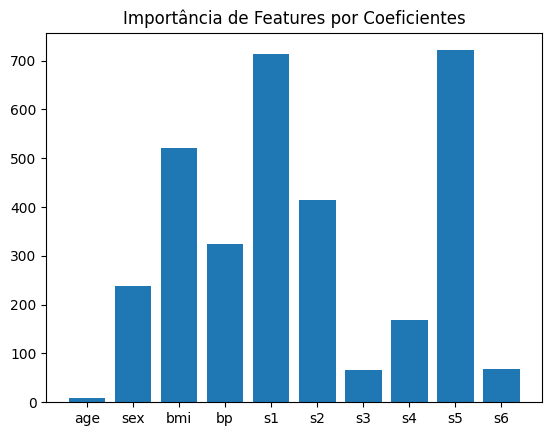

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, y)

importance = np.abs(ridge.coef_)

feature_names = np.array(diabetes.feature_names)
plt.bar(height=importance, x=feature_names)
plt.title("Importância de Features por Coeficientes")
plt.show()

Vamos importar o ``SelectFromModel`` do sklearn para selecionar as features mais importantes. 

In [6]:
from sklearn.feature_selection import SelectFromModel

# Selecionando features com importância maior que a terceira maior importância
threshold = np.sort(importance)[-3] + 0.01

# Criando o objeto SelectFromModel e selecionando as features
sfm = SelectFromModel(ridge, threshold=threshold).fit(X, y)


print(f"Features selecionadas pelo SelectFromModel: {feature_names[sfm.get_support()]}")

# treinando o modelo com as features selecionadas
ridge.fit(sfm.transform(X), y)


Features selecionadas pelo SelectFromModel: ['s1' 's5']


RidgeCV(alphas=array([1.e-06, 1.e-03, 1.e+00, 1.e+03, 1.e+06]))

## Escolhendo Features/Variáveis com Base em Correlação

Vamos usar a função make_regression do sklearn para criar um conjunto de dados de regressão com 5000 amostras e 20 features. Onde a **coluna 1 é a variável dependente** e as colunas 2 a 20 são as variáveis independentes.

Vamos usar o método ``.corr()`` para calcular a correlação entre as features e o target.

### O Método VarianceThreshold

A função sklearn.feature_selection.r_regression no scikit-learn é usada para calcular o coeficiente de correlação de Pearson entre cada recurso (regressor) e a variável alvo em um problema de regressão. Ela fornece uma pontuação que pode ser usada em um procedimento de seleção de recursos, mas não realiza a seleção de recursos por si só. A função calcula o coeficiente de correlação de Pearson para avaliar o efeito individual de cada recurso na variável alvo. No entanto, é necessário combinar essa função com outras técnicas de seleção de recursos para realizar o processo de seleção completo. Essas técnicas adicionais podem ser parte de um procedimento de seleção de recursos mais amplo.


### Prevenindo Multicolinearidade

Multicolinearidade é a situação em que duas ou mais variáveis independentes estão altamente correlacionadas entre si.
Isso infla os coeficientes das variáveis independentes e torna os resultados instáveis. Diminuindo a precisão do modelo.

In [21]:
# reproduce SelectKBest from scratch
df_diabetes = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df_diabetes['target'] = diabetes.target

df_diabetes.corr().sort_values('target', ascending=False)['target']

target    1.000000
bmi       0.586450
s5        0.565883
bp        0.441482
s4        0.430453
s6        0.382483
s1        0.212022
age       0.187889
s2        0.174054
sex       0.043062
s3       -0.394789
Name: target, dtype: float64

In [22]:
from sklearn.datasets import make_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression

selector = SelectKBest(r_regression, k=6)


X_new = selector.fit_transform(X, y)

# comparando as formas dos dados
print(X.shape)
print(X_new.shape)

# transformando o array em um dataframe
X_df = pd.DataFrame(X, columns=feature_names)

# colunas selecionadas
colunas_selecionadas = X_df.columns[selector.get_support()]

print(f"As variáveis selecionadas foram: {colunas_selecionadas.values}")




(442, 10)
(442, 6)
As variáveis selecionadas foram: ['bmi' 'bp' 's1' 's4' 's5' 's6']


<Axes: >

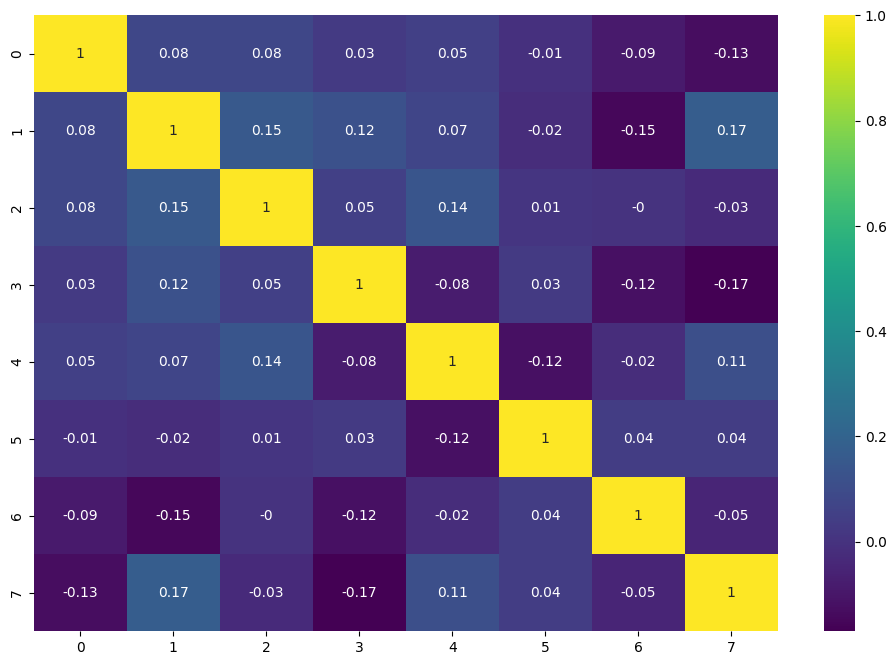

In [ ]:
# Fazendo o gráfico de pairplot com as features selecionadas

# Heatmap de correlação

plt.figure(figsize=(12, 8))
sns.heatmap(np.round(df_X_high_variance.corr(),2), annot=True, cmap='viridis')

In [ ]:
corr = np.abs(df_X_high_variance.corr())['target'].sort_values(ascending=False)

corr

KeyError: 'target'

In [ ]:
# Selecionando as features com maior correlação absoluta com a target
corr = np.abs(df_reg.corr())['target'].sort_values(ascending=False)

# Selecionando as features com correlação absoluta maior que 0.4
corr = corr[corr > 0.4]

# Selecionando as features com correlação absoluta menor que -0.4

# Removendo a correlação da target com ela mesma
corr = corr.drop('target')

# Avaliando modelo com e sem as features selecionadas
from sklearn.linear_model import LinearRegression

# # Criando o objeto do modelo de regressão linear
lr = LinearRegression()


# # Separando os dados em treino e teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

# fazendo X_train e X_test serem dataframes
df_X_train = pd.DataFrame(X_train, columns=df_reg.columns[:-1])
df_X_test = pd.DataFrame(X_test, columns=df_reg.columns[:-1])

# criando X_train e X_test com as features selecionadas
X_train_sel = df_X_train[corr.index].to_numpy()
X_test_sel = df_X_test[corr.index].to_numpy()


# # Treinando os modelos
lr.fit(X_train, y_train)

lr_sel = LinearRegression().fit(X_train_sel, y_train)

# # Avaliando o modelo
print(f"R2 com todas as features: {lr.score(X_test, y_test)}")

# # Avaliando o modelo
print(f"R2 com as features selecionadas: {lr_sel.score(X_test_sel, y_test)}")


ValueError: Shape of passed values is (75, 8), indices imply (75, 15)